In [775]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import numpy as np

pl.Config(tbl_rows=40, tbl_cols=1000)

df = pl.read_csv("../Data/Titanic/train.csv")

In [776]:
df = df.with_columns(
    (pl.col("Age") - pl.col("Age") % 5).alias("je moeder"),
    (pl.col("SibSp") + 1 + pl.col("Parch")).alias("FamilySize")
)
df = df.with_columns(
    pl.when(pl.col("FamilySize") > 4).then(1).otherwise(0).alias("IsBigFamily")
)

In [777]:
df.filter(pl.col("je moeder") < 5).sort("Survived", descending=True)

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,je moeder,FamilySize,IsBigFamily
i64,i64,i64,str,str,f64,i64,i64,str,f64,str,str,f64,i64,i32
11,1,3,"""Sandstrom, Miss. Marguerite Ru…","""female""",4.0,1,1,"""PP 9549""",16.7,"""G6""","""S""",0.0,3,0
44,1,2,"""Laroche, Miss. Simonne Marie A…","""female""",3.0,1,2,"""SC/Paris 2123""",41.5792,null,"""C""",0.0,4,0
79,1,2,"""Caldwell, Master. Alden Gates""","""male""",0.83,0,2,"""248738""",29.0,null,"""S""",0.0,3,0
173,1,3,"""Johnson, Miss. Eleanor Ileen""","""female""",1.0,1,1,"""347742""",11.1333,null,"""S""",0.0,3,0
184,1,2,"""Becker, Master. Richard F""","""male""",1.0,2,1,"""230136""",39.0,"""F4""","""S""",0.0,4,0
185,1,3,"""Kink-Heilmann, Miss. Luise Gre…","""female""",4.0,0,2,"""315153""",22.025,null,"""S""",0.0,3,0
194,1,2,"""Navratil, Master. Michel M""","""male""",3.0,1,1,"""230080""",26.0,"""F2""","""S""",0.0,3,0
262,1,3,"""Asplund, Master. Edvin Rojj Fe…","""male""",3.0,4,2,"""347077""",31.3875,null,"""S""",0.0,7,1
306,1,1,"""Allison, Master. Hudson Trevor""","""male""",0.92,1,2,"""113781""",151.55,"""C22 C26""","""S""",0.0,4,0


In [778]:

df.filter(df["FamilySize"] > 4).mean()

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,je moeder,FamilySize,IsBigFamily
f64,f64,f64,str,str,f64,f64,f64,str,f64,str,str,f64,f64,f64
392.33871,0.16129,2.774194,null,null,17.843137,3.467742,2.241935,null,58.289787,null,null,15.294118,6.709677,1.0


<Axes: xlabel='FamilySize', ylabel='Count'>

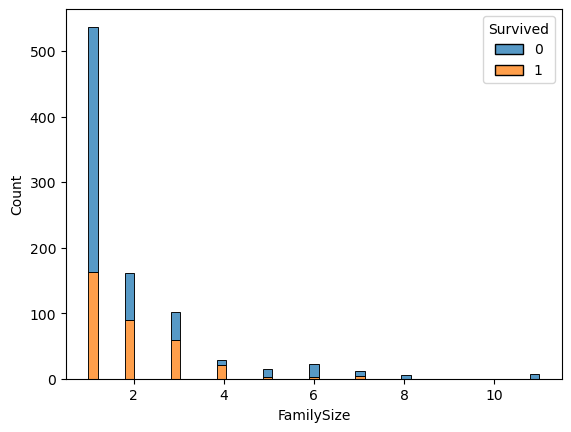

In [779]:
sns.histplot(df, x="FamilySize", hue="Survived", multiple="stack")

<Axes: xlabel='je moeder', ylabel='Count'>

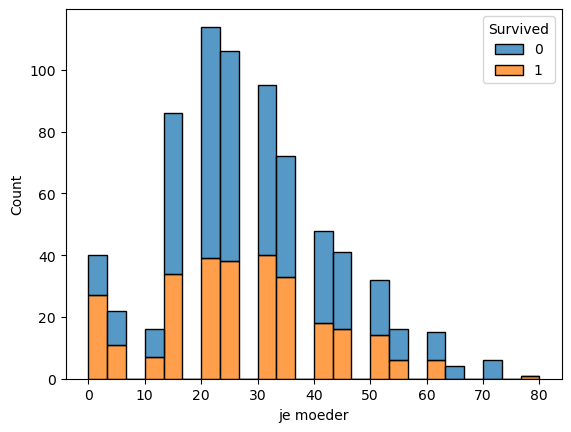

In [780]:
sns.histplot(df, x="je moeder", hue="Survived", multiple="stack") 

In [781]:
df.head()

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,je moeder,FamilySize,IsBigFamily
i64,i64,i64,str,str,f64,i64,i64,str,f64,str,str,f64,i64,i32
1,0,3,"""Braund, Mr. Owen Harris""","""male""",22.0,1,0,"""A/5 21171""",7.25,null,"""S""",20.0,2,0
2,1,1,"""Cumings, Mrs. John Bradley (Fl…","""female""",38.0,1,0,"""PC 17599""",71.2833,"""C85""","""C""",35.0,2,0
3,1,3,"""Heikkinen, Miss. Laina""","""female""",26.0,0,0,"""STON/O2. 3101282""",7.925,null,"""S""",25.0,1,0
4,1,1,"""Futrelle, Mrs. Jacques Heath (…","""female""",35.0,1,0,"""113803""",53.1,"""C123""","""S""",35.0,2,0
5,0,3,"""Allen, Mr. William Henry""","""male""",35.0,0,0,"""373450""",8.05,null,"""S""",35.0,1,0


In [782]:
def standardize(column):
    return (column - column.mean()) / column.std()

# Cleaning columns
df = df.with_columns(
    [
        pl.when(pl.col("Sex")=="male").then(pl.lit(1)).otherwise(pl.lit(0)).alias("Sex"),
        pl.col("Age").fill_null(pl.col("Age").median().over("Pclass")),
    ]
)

# Feature engineering
df = df.with_columns(
    [
        pl.col("Name").str.extract(r", (.*?)\.").alias("Title"),
        pl.when(pl.col("Cabin").is_not_null()).then(1).otherwise(0).alias("HasCabinRegistered"),
        (pl.col("SibSp") + pl.col("Parch") + 1).alias("FamilySize"),
        pl.col("Cabin").str.extract("^([A-Za-z]){1}").alias("Deck"),
        pl.col("Cabin").str.extract("^.([0-9]+)").cast(pl.Int64).alias("RoomNumber"),
    ]
)

# Bin Features with quantiles
df = df.with_columns(
    [
        pl.when(pl.col("Age") < pl.col("Age").quantile(.25)).then(pl.lit(1))
        .when(pl.col("Age") < pl.col("Age").quantile(.50)).then(pl.lit(2))
        .when(pl.col("Age") < pl.col("Age").quantile(.75)).then(pl.lit(3))
        .otherwise(4)
        .alias("AgeGroupQuantiles"),
        pl.when(pl.col("Fare") < pl.col("Fare").quantile(.25)).then(1)
        .when(pl.col("Fare") < pl.col("Fare").quantile(.50)).then(2)
        .when(pl.col("Fare") < pl.col("Fare").quantile(.75)).then(3)
        .otherwise(4).alias("FareGroupQuantiles")
    ]
)

# Bin Featuers with domain knowledge

# Second order Feature engineering
df = df.with_columns(
        pl.when(pl.col("Title").is_in(["Jonkheer", "the Countess", "Lady", "Sir", "Don", "Master", "Major", "Capt", "Rev", "Dr", "Col"]))
        .then(pl.lit(1))
        .otherwise(pl.lit(0))
        .alias("HasTitle"),
)

# Dummy Features
df = df.to_dummies(
    [
        "Embarked", 
        "Deck"
    ],
    drop_first=True
)

# Drop Features
df = df.drop(
    "Name",
    "Ticket",
    "PassengerId",
    "Embarked_null",
    "Cabin",
    "RoomNumber"
)

# Third order Feature engineering
# df = df.with_columns(

# )

df.head()

Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,je moeder,FamilySize,IsBigFamily,Title,HasCabinRegistered,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,AgeGroupQuantiles,FareGroupQuantiles,HasTitle
i64,i64,i32,f64,i64,i64,f64,u8,u8,f64,i64,i32,str,i32,u8,u8,u8,u8,u8,u8,u8,u8,i32,i32,i32
0,3,1,22.0,1,0,7.25,0,0,20.0,2,0,"""Mr""",0,0,0,0,0,0,0,0,0,2,1,0
1,1,0,38.0,1,0,71.2833,1,0,35.0,2,0,"""Mrs""",1,0,0,1,0,0,0,0,0,4,4,0
1,3,0,26.0,0,0,7.925,0,0,25.0,1,0,"""Miss""",0,0,0,0,0,0,0,0,0,3,2,0
1,1,0,35.0,1,0,53.1,0,0,35.0,2,0,"""Mrs""",1,0,0,1,0,0,0,0,0,3,4,0
0,3,1,35.0,0,0,8.05,0,0,35.0,1,0,"""Mr""",0,0,0,0,0,0,0,0,0,3,2,0


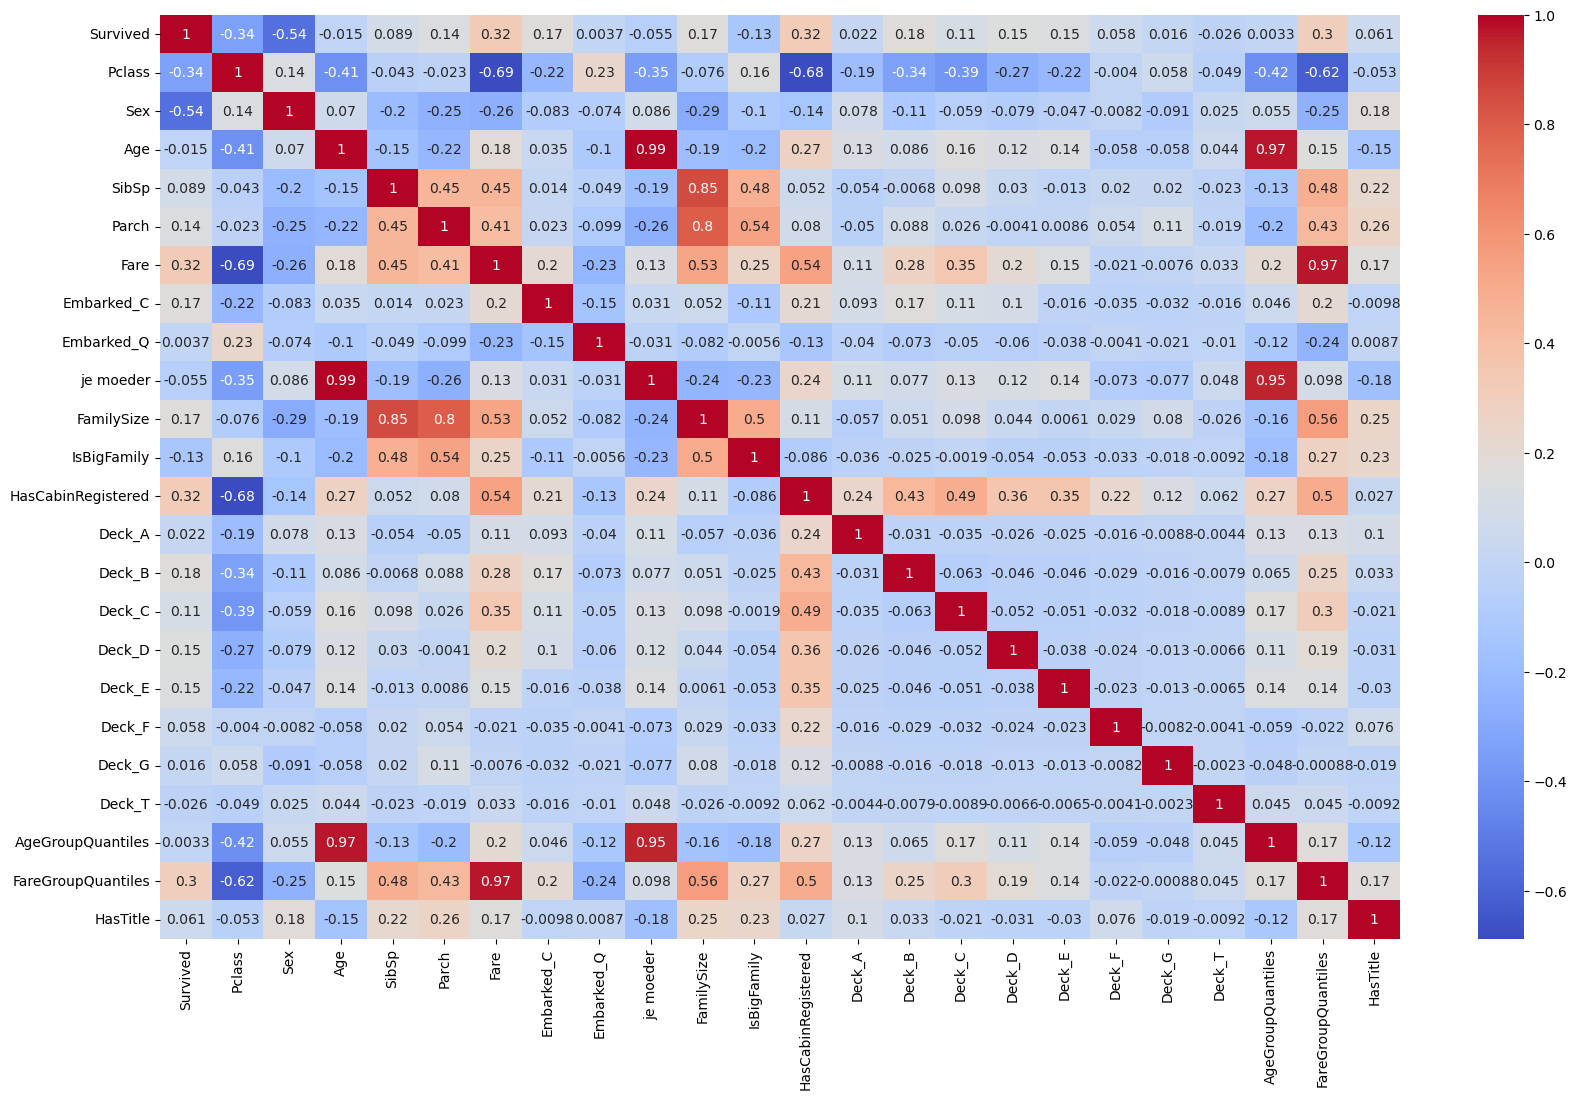

In [783]:
# df.write_csv("../Data/advancedDataframe.csv")

def heatmap(df, figsize=(20, 12), method="spearman"):
    corr_matrix = df.select(
        pl.col(pl.selectors.NUMERIC_DTYPES)
    ).to_pandas().corr(method=method)

    plt.figure(figsize=figsize)
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")

heatmap(df)


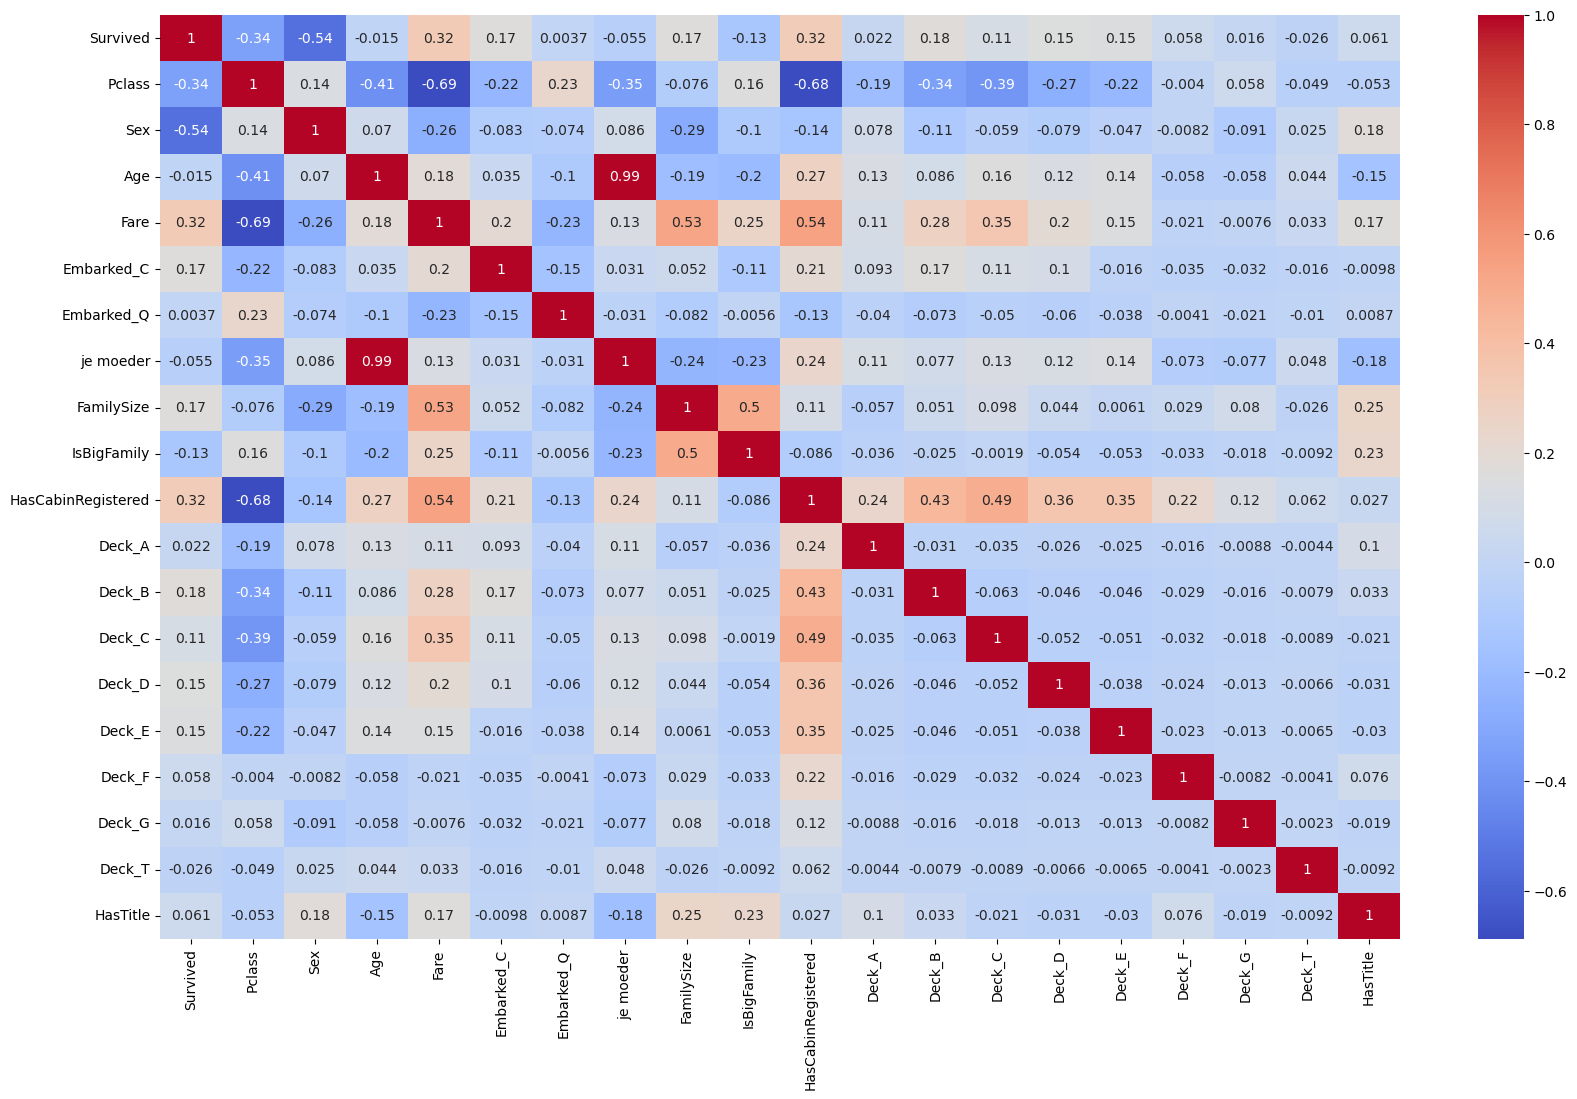

In [784]:
df = df.drop("SibSp", "Parch", "AgeGroupQuantiles", "FareGroupQuantiles")

heatmap(df)

In [785]:
deck_columns = [column for column in df.columns if column.startswith("Deck_")]
df = df.with_columns(
    ((pl.col("Deck_B") == 1) | (pl.col("Deck_C") == 1) | (pl.col("Deck_D") == 1) | (pl.col("Deck_E") == 1)).cast(pl.Int32).alias("HighSurvivalDecks")
)
df = df.drop("HasCabinRegistered")
economic_columns = ["Fare", "Pclass", "HighSurvivalDecks"]

df[["Survived", "HighSurvivalDecks"]].sum()

Survived,HighSurvivalDecks
i64,i32
342,171


Text(0, 0.5, 'Cumulatieve verklaarde variantie')

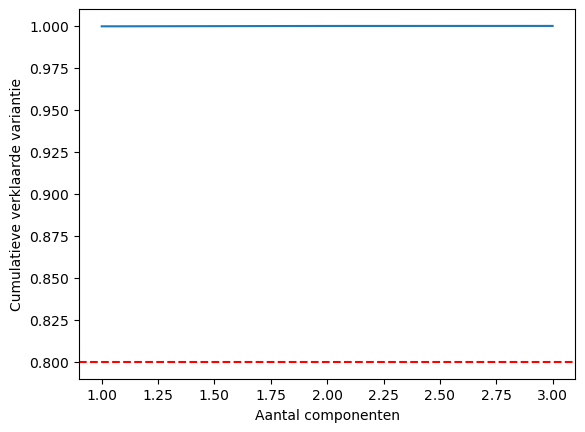

In [786]:
pca = PCA()

pca.fit(df[economic_columns])

plt.plot(range(1, len(pca.explained_variance_ratio_)+1), np.cumsum(pca.explained_variance_ratio_))
plt.axhline(y=0.8, color='r', linestyle='--')  # 80% threshold
plt.xlabel('Aantal componenten')
plt.ylabel('Cumulatieve verklaarde variantie')

In [787]:
pca_result = pca.fit_transform(df[economic_columns])

df = df.with_columns(
    pl.lit(pca_result[:, 0]).alias("Ses_1"),
    pl.lit(pca_result[:, 1]).alias("Ses_2"),
    pl.lit(pca_result[:, 2]).alias("Ses_3"),
)

df.head()

Survived,Pclass,Sex,Age,Fare,Embarked_C,Embarked_Q,je moeder,FamilySize,IsBigFamily,Title,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,HasTitle,HighSurvivalDecks,Ses_1,Ses_2,Ses_3
i64,i64,i32,f64,f64,u8,u8,f64,i64,i32,str,u8,u8,u8,u8,u8,u8,u8,u8,i32,i32,f64,f64,f64
0,3,1,22.0,7.25,0,0,20.0,2,0,"""Mr""",0,0,0,0,0,0,0,0,0,0,-24.960115,0.464899,0.062053
1,1,0,38.0,71.2833,1,0,35.0,2,0,"""Mrs""",0,0,1,0,0,0,0,0,0,1,39.092533,-1.103268,0.312497
1,3,0,26.0,7.925,0,0,25.0,1,0,"""Miss""",0,0,0,0,0,0,0,0,0,0,-24.285149,0.471705,0.061381
1,1,0,35.0,53.1,0,0,35.0,2,0,"""Mrs""",0,0,1,0,0,0,0,0,0,1,20.910166,-1.2866,0.330577
0,3,1,35.0,8.05,0,0,35.0,1,0,"""Mr""",0,0,0,0,0,0,0,0,0,0,-24.160156,0.472965,0.061257


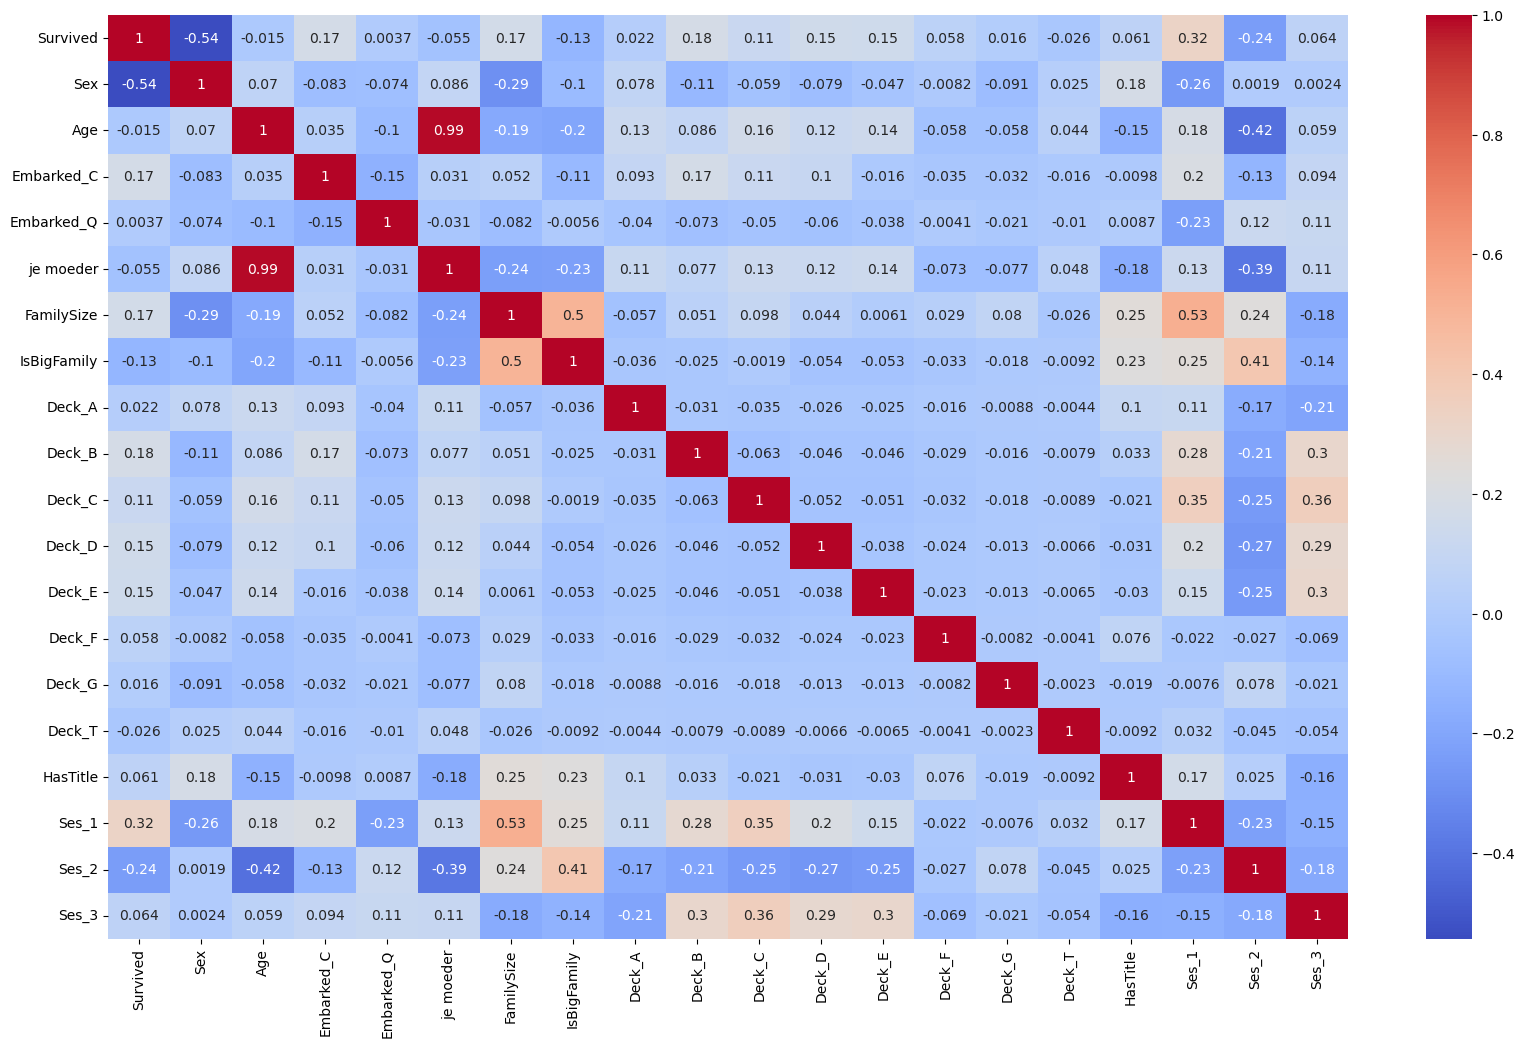

In [788]:
df = df.drop("Fare", "Pclass", "HighSurvivalDecks")
heatmap(df)

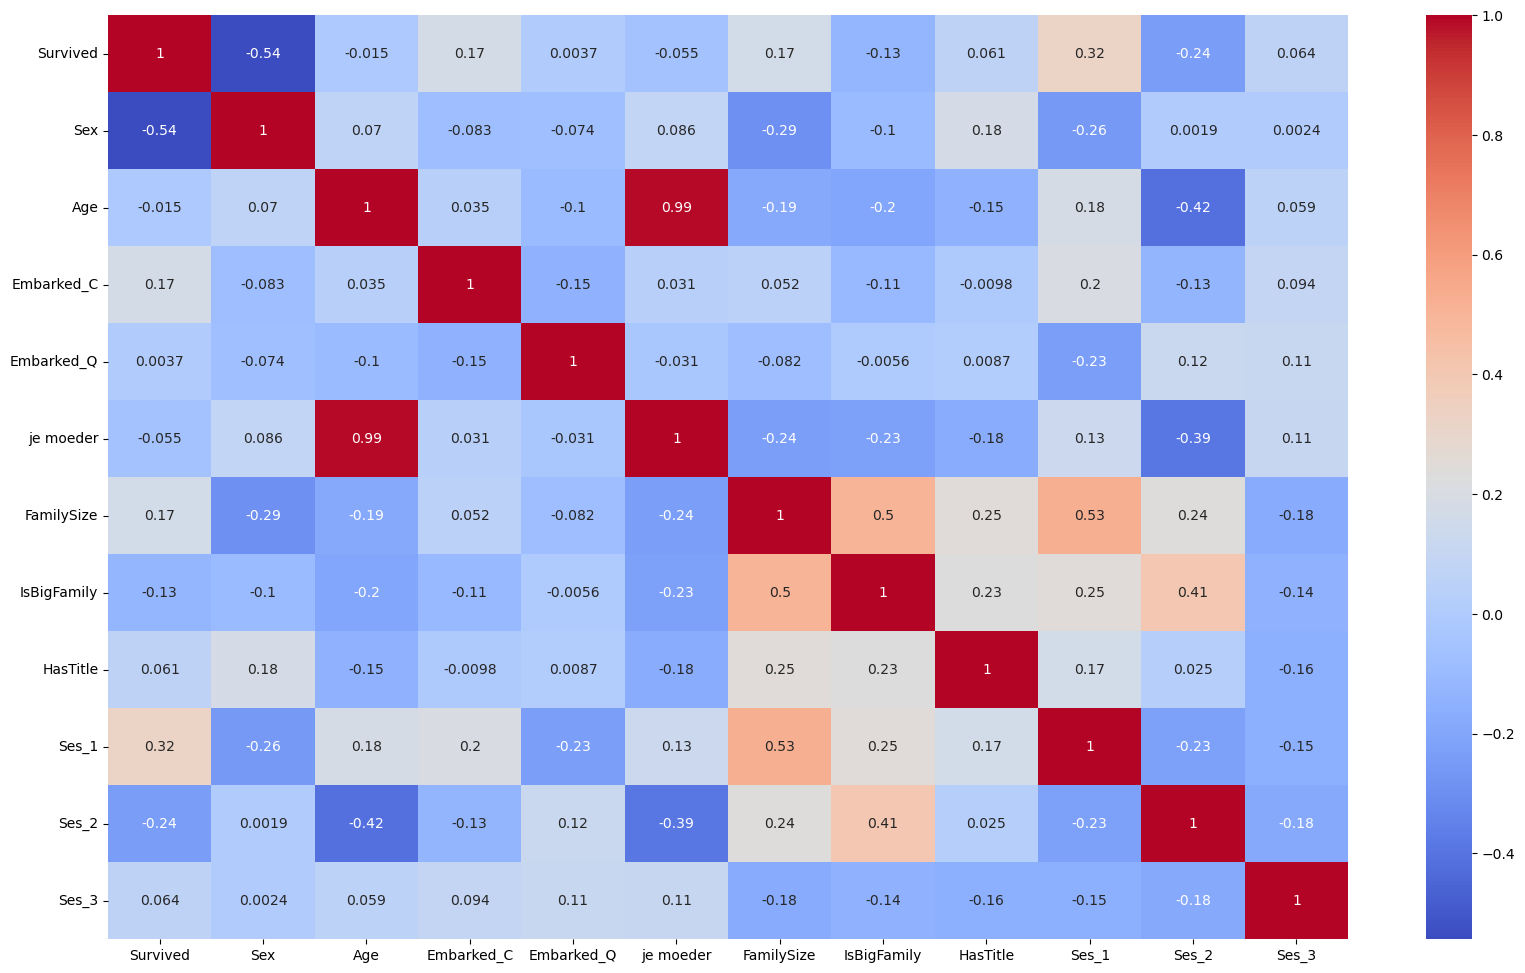

In [789]:
df = df.drop(deck_columns)

heatmap(df)

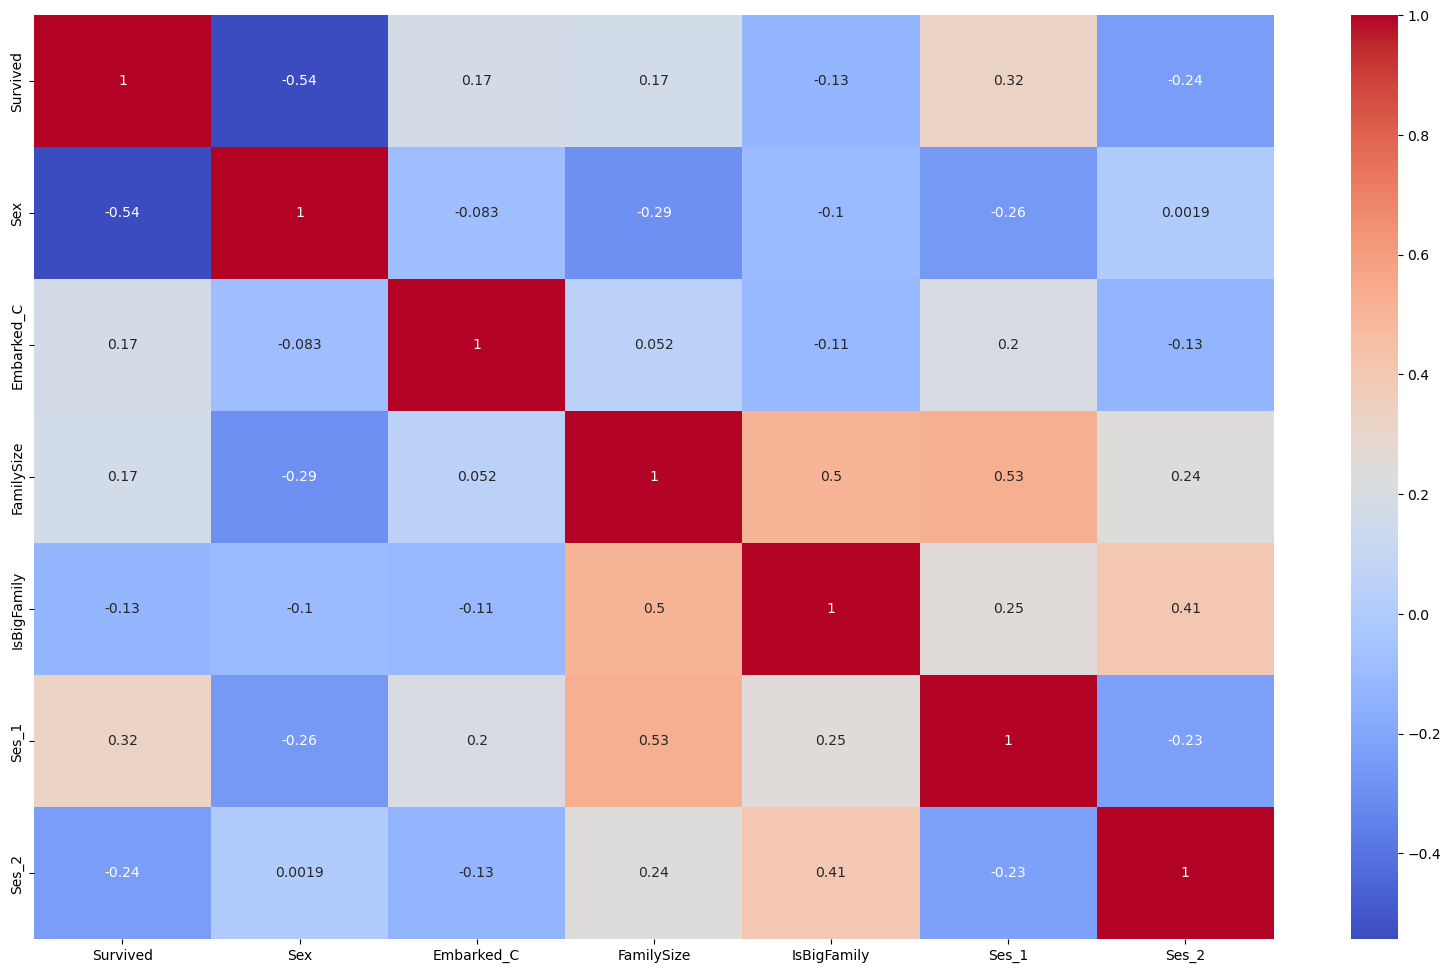

In [790]:
df = df.drop("HasTitle", "Title", "Embarked_Q", "Ses_3", "Age", "je moeder")

heatmap(df)

In [791]:
pca = PCA()
pca_result = pca.fit_transform(df[["IsBigFamily", "FamilySize"]])

df = df.with_columns(
    pl.lit(pca_result[:, 0]).alias("Fam_1"),
    pl.lit(pca_result[:, 1]).alias("Fam_2")
).drop("IsBigFamily", "FamilySize")

In [ ]:
pca = PCA()
pca_result = pca.fit_transform(df[["Ses_1", "Fam_1"]])

df = df.with_columns(
    pl.lit(pca_result[:, 0]).alias("Test_1"),
    pl.lit(pca_result[:, 1]).alias("Test_2")
).drop("Ses_1", "Fam_1")

In [793]:
df.head()

Survived,Sex,Embarked_C,Ses_1,Ses_2,Fam_1,Fam_2
i64,i32,u8,f64,f64,f64,f64
0,1,0,-24.960115,0.464899,0.08566,-0.081273
1,0,1,39.092533,-1.103268,0.08566,-0.081273
1,0,0,-24.285149,0.471705,-0.90604,0.047301
1,0,0,20.910166,-1.2866,0.08566,-0.081273
0,1,0,-24.160156,0.472965,-0.90604,0.047301


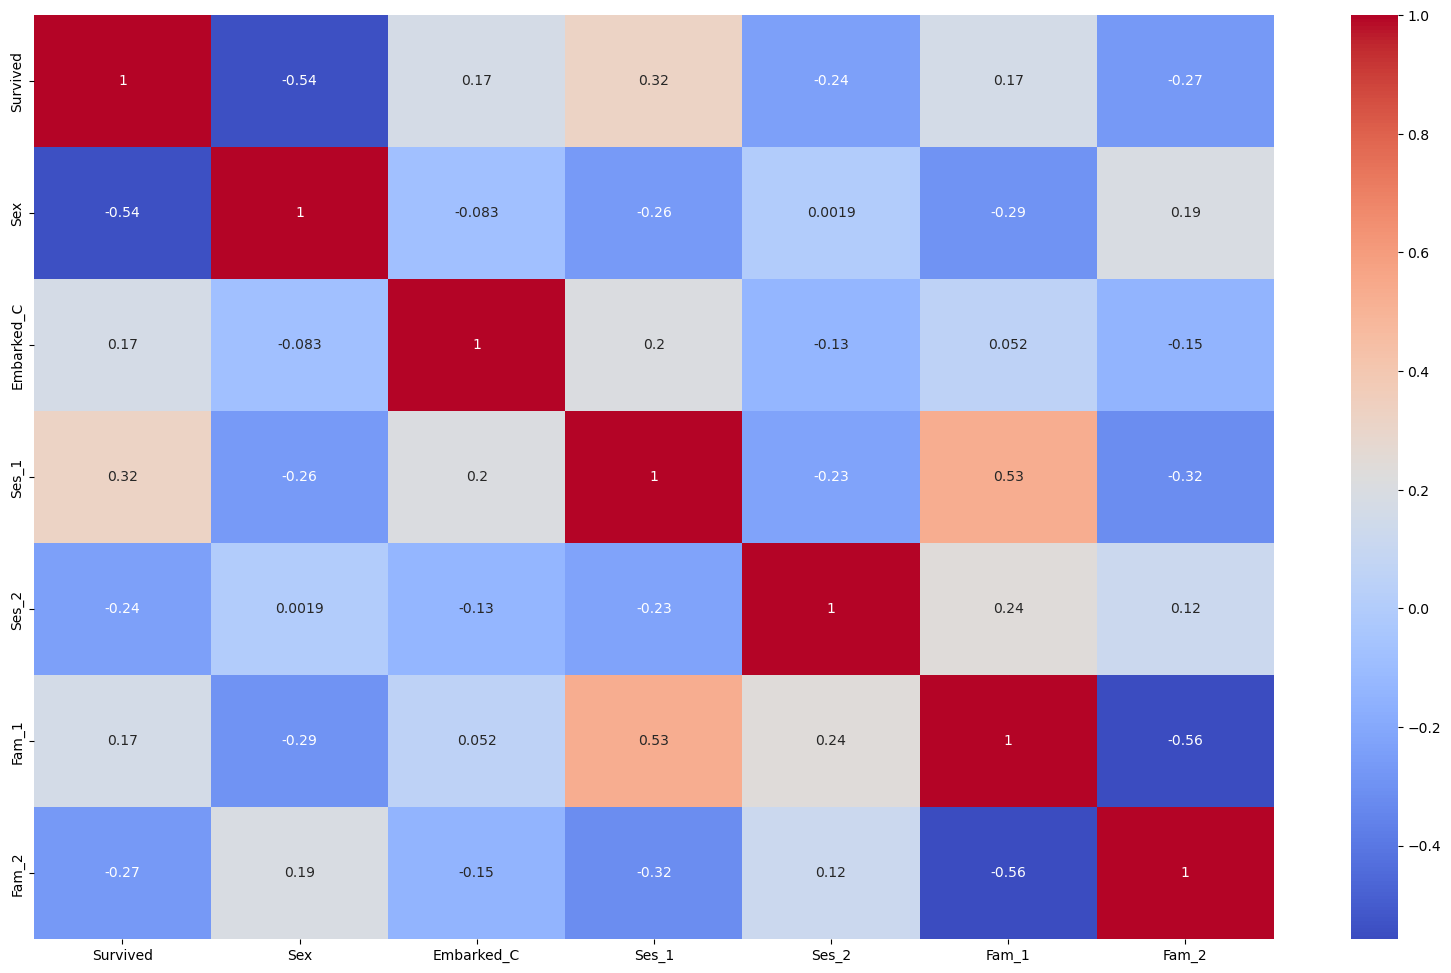

In [794]:
heatmap(df)

In [ ]:
df.write_csv("../Data/Titanic/advancedDataframe.csv")